In [28]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import numpy as np
import re
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
from tqdm import tqdm

In [29]:
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

In [30]:
# Preprocessing function
def preprocess_text(text):
    # Convert to lowercase and remove special characters (keeping apostrophes)
    text = text.lower()
    text = re.sub(r"[^a-zA-Z'\s]", ' ', text)

    # Tokenize and remove stopwords
    tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    important_words = {'not', 'no', 'never', 'none', 'nobody', 'nowhere', 'neither', 'nor',
                       "doesn't", "isn't", "wasn't", "shouldn't", "wouldn't", "couldn't", "won't",
                       "can't", "don't"}
    tokens = [token for token in tokens if token not in stop_words or token in important_words]

    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(token) for token in tokens]

    return ' '.join(tokens)

In [31]:
# Load and preprocess the dataset
df = pd.read_csv("E:/absa_farhan/FinalDataset.csv")
df['text'] = df['text'].apply(preprocess_text)

In [32]:
print(df.head())

                                                text     span     label  \
0  positive point camera quality good not enough ...  battery  positive   
1  using day concern regarding phone pro excellen...  battery  positive   
2  thing good phone camera quality display batter...  battery  positive   
3  phone awesome camera quality super awesome eve...  battery  positive   
4  good battery performance not goodlooks good pe...   design  positive   

   ordinal  
0        0  
1        0  
2        0  
3        0  
4        0  


In [33]:
print(df.tail())

                                                  text     span     label  \
779  disappointed display quality offer low brightn...  display  negative   
780  superb phone best phone k camera warms little ...   camera  positive   
781  disappointed display quality offer low brightn...  display  negative   
782  everything thing device good camera awesome ma...  battery  positive   
783  high quality camera iphone new megapixel main ...   camera   neutral   

     ordinal  
779        3  
780        3  
781        3  
782        4  
783        4  


In [34]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 784 entries, 0 to 783
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   text     784 non-null    object
 1   span     784 non-null    object
 2   label    784 non-null    object
 3   ordinal  784 non-null    int64 
dtypes: int64(1), object(3)
memory usage: 24.6+ KB
None


In [35]:
print(df.describe())

          ordinal
count  784.000000
mean     0.182398
std      0.531170
min      0.000000
25%      0.000000
50%      0.000000
75%      0.000000
max      4.000000


In [36]:
# Encode labels and aspects
label_encoder = LabelEncoder()
df['label_encoded'] = label_encoder.fit_transform(df['label'])

<Axes: ylabel='Count'>

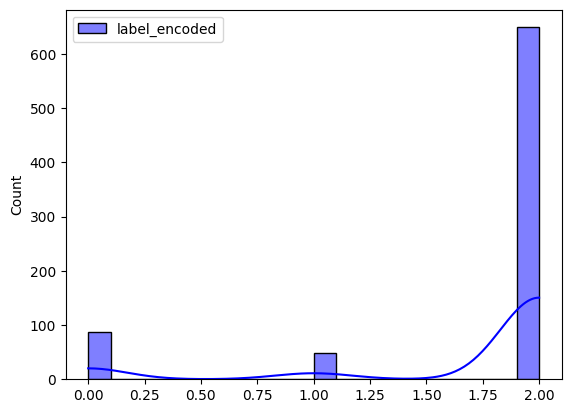

In [37]:
sns.histplot([df["label_encoded"]], bins=20, kde=True, alpha=0.5, palette=["blue"])

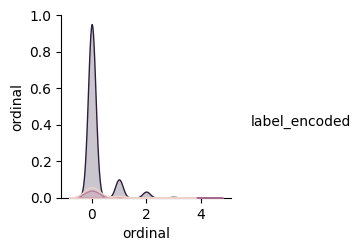

In [38]:
sns.pairplot(df, hue="label_encoded")

In [39]:
# Split the data into training and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)

In [40]:
# Define the dataset class
class AspectSentimentDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        text = self.data.iloc[index]['text']
        aspect = self.data.iloc[index]['span']
        inputs = self.tokenizer.encode_plus(
            aspect,
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_token_type_ids=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': inputs['input_ids'].flatten(),
            'attention_mask': inputs['attention_mask'].flatten(),
            'token_type_ids': inputs['token_type_ids'].flatten(),
            'labels': torch.tensor(self.data.iloc[index]['label_encoded'], dtype=torch.long)
        }

In [41]:
# Initialize tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
num_labels = len(label_encoder.classes_)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=num_labels)

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [42]:
# Prepare datasets and dataloaders
train_dataset = AspectSentimentDataset(train_df, tokenizer, max_len=128)
val_dataset = AspectSentimentDataset(val_df, tokenizer, max_len=128)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

In [43]:
# Training settings
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
num_epochs = 3

C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [44]:
# Initialize history dictionary for plotting
history = {
    'accuracy': [],
    'val_accuracy': [],
    'loss': [],
    'val_loss': []
}

In [45]:
# Lists to hold true and predicted labels for confusion matrix
y_true = []
y_pred = []

In [46]:
from tqdm import tqdm

In [47]:
# Training loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    train_pbar = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Train]')
    
    for batch in train_pbar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        token_type_ids = batch['token_type_ids'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        _, predicted = torch.max(outputs.logits, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
        train_accuracy = 100 * correct_train / total_train
        train_pbar.set_postfix({'loss': train_loss / (train_pbar.n + 1), 'acc': train_accuracy})
    
    history['accuracy'].append(train_accuracy)
    history['loss'].append(train_loss / len(train_loader))

    # Validation
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    val_pbar = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} [Validation]')

    with torch.no_grad():
        for batch in val_pbar:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            token_type_ids = batch['token_type_ids'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, labels=labels)
            val_loss += outputs.loss.item()
            _, predicted = torch.max(outputs.logits, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

            # Collect predictions for confusion matrix
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

            val_accuracy = 100 * correct_val / total_val
            val_pbar.set_postfix({'loss': val_loss / (val_pbar.n + 1), 'acc': val_accuracy})

    history['val_accuracy'].append(val_accuracy)
    history['val_loss'].append(val_loss / len(val_loader))

    print(f'Epoch {epoch + 1}/{num_epochs}, Training Accuracy: {train_accuracy:.2f}%, Validation Accuracy: {val_accuracy:.2f}%')

Epoch 1/3 [Train]:   0%|                            | 0/40 [00:00<?, ?it/s]C:\Users\ASUS\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\models\bert\modeling_bert.py:439: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:555.)
  attn_output = torch.nn.functional.scaled_dot_product_attention(
Epoch 1/3 [Train]:   5%| | 2/40 [00:01<00:22,  1.67it/s, loss=0.851, acc=87Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 1/3 [Train]:  12%|▏| 5/40 [00:02<00:14,  2.46it/s, loss=0.773, acc=88Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the retur

Epoch 1/3, Training Accuracy: 81.66%, Validation Accuracy: 86.62%


Epoch 2/3 [Train]:   0%|                            | 0/40 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 2/3 [Train]:   5%| | 2/40 [00:00<00:13,  2.80it/s, loss=0.347, acc=87Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 2/3 [Train]:  15%|▏| 6/40 [00:02<00:12,  2.80it/s, loss=0.369, acc=86Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 2/3 [Train]:  28%|▎| 11/40 [00:03<00:10,  2.80it/s, loss=0.396, acc=8Be aware, overflowing 

Epoch 2/3, Training Accuracy: 84.85%, Validation Accuracy: 95.54%


Epoch 3/3 [Train]:   0%|                            | 0/40 [00:00<?, ?it/s]Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 3/3 [Train]:   2%| | 1/40 [00:00<00:14,  2.78it/s, loss=0.224, acc=93Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 3/3 [Train]:  10%| | 4/40 [00:01<00:12,  2.78it/s, loss=0.222, acc=95Be aware, overflowing tokens are not returned for the setting you have chosen, i.e. sequence pairs with the 'longest_first' truncation strategy. So the returned list will always be empty even if some tokens have been removed.
Epoch 3/3 [Train]:  15%|▏| 6/40 [00:02<00:12,  2.79it/s, loss=0.228, acc=94Be aware, overflowing 

Epoch 3/3, Training Accuracy: 94.74%, Validation Accuracy: 98.09%


In [48]:
# Overall accuracy calculation
overall_train_accuracy = 100 * correct_train / total_train
overall_val_accuracy = 100 * correct_val / total_val

In [49]:
print(f"Overall Training Accuracy: {overall_train_accuracy:.2f}%")
print(f"Overall Validation Accuracy: {overall_val_accuracy:.2f}%")

Overall Training Accuracy: 94.74%
Overall Validation Accuracy: 98.09%


In [50]:
# Save the model
torch.save(model.state_dict(), 'aspect_sentiment_model.pth')

In [51]:
# Define Confusion Matrix Function
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [52]:
# Define Classification Report Function
def generate_classification_report(y_true, y_pred, labels):
    report = classification_report(y_true, y_pred, target_names=labels)
    print("Classification Report:\n", report)

In [53]:
def plot_training_curves(history):
    epochs = range(1, len(history['accuracy']) + 1)
    
    # Accuracy Curves
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['accuracy'], 'b', label='Training Accuracy')
    plt.plot(epochs, history['val_accuracy'], 'r', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    # Loss Curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['loss'], 'b', label='Training Loss')
    plt.plot(epochs, history['val_loss'], 'r', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

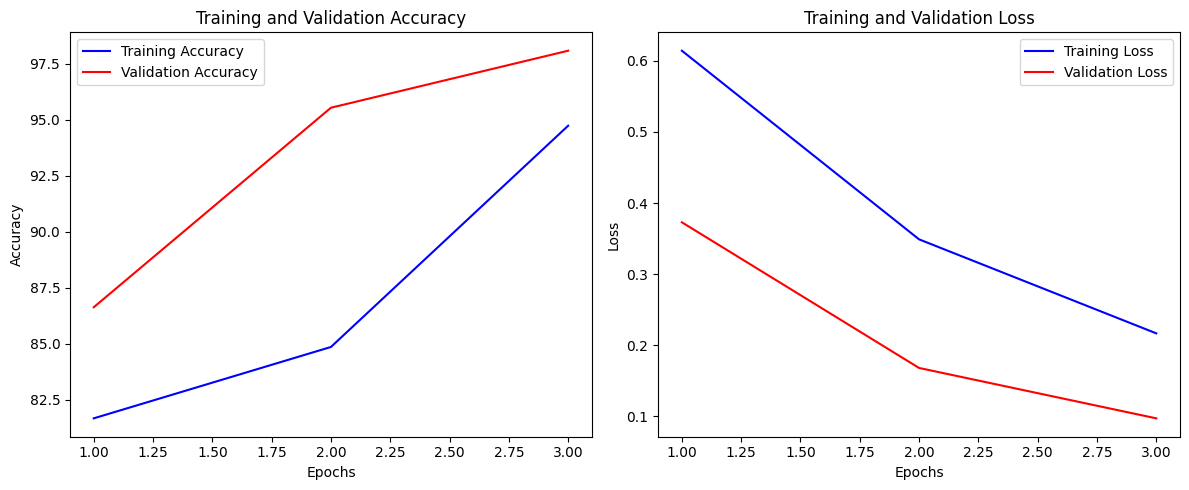

In [54]:
# Plot training curves
plot_training_curves(history)

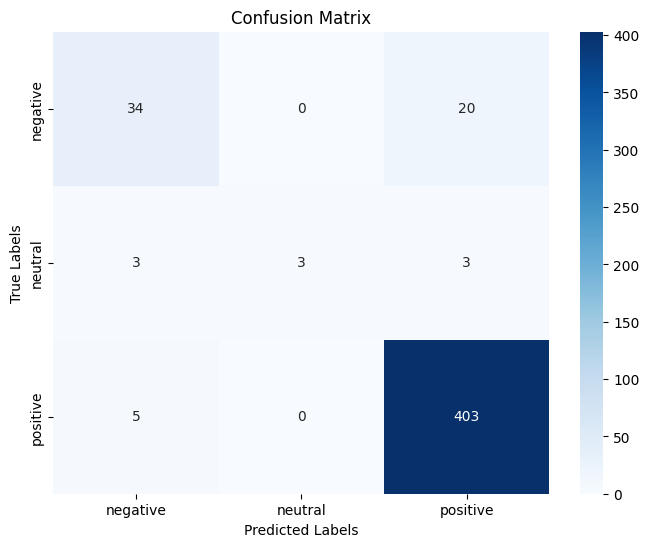

In [55]:
# Generate confusion matrix and classification report
labels_list = label_encoder.classes_  # Ensure to get the class labels
plot_confusion_matrix(y_true, y_pred, labels=labels_list)  # Plot the confusion matrix

In [56]:
generate_classification_report(y_true, y_pred, labels=labels_list)  # Generate the classification report

Classification Report:
               precision    recall  f1-score   support

    negative       0.81      0.63      0.71        54
     neutral       1.00      0.33      0.50         9
    positive       0.95      0.99      0.97       408

    accuracy                           0.93       471
   macro avg       0.92      0.65      0.72       471
weighted avg       0.93      0.93      0.93       471



In [57]:
def load_saved_model(model_path):
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=3)
    model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))
    model.to('cpu')
    model.eval()
    return model

In [58]:
loaded_model = load_saved_model('./aspect_sentiment_model.pth')

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\ASUS\AppData\Local\Temp\ipykernel_4860\3249253587.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serializat

In [59]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import re

def predict_sentiments(text, model, tokenizer, label_encoder, device):
    aspects = ['battery', 'display', 'design', 'performance', 'camera']
    results = {}

    model.eval()

    for aspect in aspects:
        # Check if the aspect is mentioned in the text
        aspect_pattern = r'\b' + re.escape(aspect) + r'\b'
        if re.search(aspect_pattern, text, re.IGNORECASE):
            # Find the sentence containing the aspect
            sentences = re.split(r'(?<=[.!?])\s+', text)
            relevant_sentence = next((s for s in sentences if re.search(aspect_pattern, s, re.IGNORECASE)), text)

            # Prepare input for the model
            inputs = tokenizer.encode_plus(
                aspect,
                relevant_sentence,
                add_special_tokens=True,
                max_length=128,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_token_type_ids=True,
                return_tensors='pt'
            )

            # Make prediction
            with torch.no_grad():
                outputs = model(
                    inputs['input_ids'].to(device),
                    attention_mask=inputs['attention_mask'].to(device),
                    token_type_ids=inputs['token_type_ids'].to(device)
                )

            _, predicted = torch.max(outputs.logits, 1)
            sentiment = label_encoder.inverse_transform([predicted.item()])[0]

            results[aspect] = sentiment

    return results

In [60]:
# Assuming you have already initialized these:
# model = BertForSequenceClassification.from_pretrained('./aspect_sentiment_model.pth')
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# label_encoder = LabelEncoder()  # This should be the same encoder used during training
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# model.to(device)

# predictions = predict_sentiments(text, model, tokenizer, label_encoder, device)

# for aspect, sentiment in predictions.items():
#     print(f"Aspect: {aspect}, Sentiment: {sentiment}")

In [61]:
text = "battery doesn't last long"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: negative


In [62]:
text = "battery short life"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: negative


In [63]:
text = "design is very old"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: design, Sentiment: negative


In [64]:
text = "design is latest technology"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: design, Sentiment: positive


In [65]:
text = "battery is drains very fast with short battery life"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: positive


In [66]:
text = "picture from rear camera is crystal clear"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: camera, Sentiment: positive


In [67]:
text = "picture from rear camera is blur"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: camera, Sentiment: neutral


In [68]:
text = "it becomes too too too hot ,iam so disappointed with this brand . there is no difference between 4g and 5g . battery was weak iam charging twice a day,for basic level of usage itself."

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: negative


In [69]:
text = "having big one major problem it's very fast battery draining"

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: positive


In [70]:
text = '''Realme p1 5g is the one of the best smart phone under 15k.. camera it's ok
Battery 🔋 maximum 1days
Display is amoled so nice 👍
Design very nice
Performance.. mediatek 7050 is very powerful.. free fire 60fps....and...Bgmi.. smooth extreme..💪💪.. I Love 💗 this phone..'''

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: positive
Aspect: display, Sentiment: positive
Aspect: design, Sentiment: positive
Aspect: performance, Sentiment: positive
Aspect: camera, Sentiment: positive


In [71]:
text = '''
But battery backup very poor
Atleast one day not stand by battery backup
Very fast drain the battery
Worst battery
Not go to buy this phone'''

predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

for aspect, sentiment in predictions.items():
    print(f"Aspect: {aspect}, Sentiment: {sentiment}")

Aspect: battery, Sentiment: negative


In [72]:
import spacy

# Load the spaCy English model
nlp = spacy.load("en_core_web_sm")

In [73]:
def split_text(text):
    # First, split by newline characters
    split_by_newlines = text.split('\n')
    all_sentences = []
    
    for part in split_by_newlines:
        if part.strip():  # Ignore empty parts
            all_sentences.extend(split_on_conjunctions(part))
    
    return all_sentences

In [74]:
def split_on_conjunctions(text):
    doc = nlp(text)
    sentences = []
    current_sentence = []
    
    for token in doc:
        current_sentence.append(token.text)
        
        # If we encounter a coordinating conjunction or new sentence, split
        if token.dep_ == 'cc' or token.text == '.':
            sentences.append(' '.join(current_sentence).strip())
            current_sentence = []
    
    # Add the final sentence if any
    if current_sentence:
        sentences.append(' '.join(current_sentence).strip())
    
    return sentences

In [75]:
# Test case
text = '''Design - Awesome Looking and Dimensity 7050 5G Processor - Good  Amoled Display - Decent
Sound Experience is also Good but Camera Quality is superb'''

sentences = split_text(text)

# Output each split sentence
for idx, sentence in enumerate(sentences):
    print(f"Sentence {idx+1}: {sentence}")

Sentence 1: Design - Awesome Looking and
Sentence 2: Dimensity 7050 5 G Processor - Good   Amoled Display - Decent
Sentence 3: Sound Experience is also Good but
Sentence 4: Camera Quality is superb


In [76]:
def predict_sentences(text):
    text = preprocess_text(text)
    
    sentences = split_text(text)
    
    rating =3
    c=0
    
    for text in sentences :
        
        print(text)
        print()
        
        predictions = predict_sentiments(text, loaded_model, tokenizer, label_encoder, device='cpu')

        for aspect, sentiment in predictions.items():
            print(f"Aspect: {aspect}, Sentiment: {sentiment}")
            
            if sentiment == 'positive':
                rating +=1
            elif sentiment == 'negative':
                rating -=1
            else:
                rating +=0.5
                
            c+=1
    print('Rating : ', rating+(5-c))

In [77]:
text = '''Design - Awesome Looking
Dimensity 7050 5G Processor - Good
Amoled Display - Decent
Sound Experience is also Good
Camera Quality - superB
Smoothly Running All Apps.'''
predict_sentences(text)

design awesome looking dimensity g processor good amoled display decent sound experience also good camera quality superb smoothly running apps

Aspect: display, Sentiment: positive
Aspect: design, Sentiment: positive
Aspect: camera, Sentiment: positive
Rating :  8


In [78]:
text = '''SERIOUSLY IT'S TOO GOOD.
GAME IS SMOOTH IN BGMI BASIS NO.NO.NO..IT'S OVER SMOOTH.
YOU FEEL ALWAYS COOL YOUR PHONE..CAMERA QUALITY..OHO.OHO.OHO..NICE'''
predict_sentences(text)

seriously 's good game smooth bgmi basis no no no 's smooth feel always cool phone camera quality oho oho oho nice

Aspect: camera, Sentiment: positive
Rating :  8


In [79]:
text = '''The phone in this price range
Camera quality is not that good
Very bad display
Battery back poor'''
predict_sentences(text)

phone price range camera quality not good bad display battery back poor

Aspect: battery, Sentiment: negative
Aspect: display, Sentiment: negative
Aspect: camera, Sentiment: negative
Rating :  2


In [80]:
text = '''it becomes too too too hot ,iam so disappointed with this brand . there is no difference between 4g and 5g . battery was weak iam charging twice a day,for basic level of usage itself.'''
predict_sentences(text)

becomes hot iam disappointed brand no difference g g battery weak iam charging twice day basic level usage

Aspect: battery, Sentiment: negative
Rating :  6
